<a href="https://colab.research.google.com/github/oneraghavan/machine-learning-implementations/blob/master/notebooks/comp/pneumothorax/pneumothorax_fastai_starter_U_Net_128x128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!pip install pydicom

     |████████████████████████████████| 7.0MB 8.0MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
mkdir ~/.kaggle

In [0]:
!cp gdrive/My\ Drive/kaggle.json ~/.kaggle

In [0]:
!cp gdrive/My\ Drive/istio-3a8f1c0fda5f.json .

In [0]:
ls /root/.kaggle/

kaggle.json


In [0]:
!kaggle datasets list -s Pneumothorax

ref                                                           title                                               size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  ----  -------------------  -------------  
jesperdramsch/siim-acr-pneumothorax-segmentation-data         SIIM ACR Pneumothorax Segmentation Data              2GB  2019-06-25 20:18:45            464  
anisayari/siimacrpneumothoraxsegmentationzip-dataset          siim-acr-pneumothorax-segmentation.zip dataset       6GB  2019-06-27 09:31:46            326  
tanreinama/siimacr-pneumothorax-segmentation-downloaded-file  SIIM-ACR Pneumothorax Segmentation Downloaded File   2GB  2019-06-26 00:56:41             19  
robertburbidge/pneumothorax_small                             Pneumothorax 128x128                                92MB  2019-06-29 13:33:28              0  
adityaecdrid/xtra-pneumothorax-dataset                    

In [0]:
!kaggle datasets download jesperdramsch/siim-acr-pneumothorax-segmentation-data

 99% 1.51G/1.52G [00:21<00:00, 137MB/s]
100% 1.52G/1.52G [00:21<00:00, 76.6MB/s]


In [0]:
!unzip siim-acr-pneumothorax-segmentation-data.zip

In [0]:
!ls

dicom-images-test
dicom-images-train
download_images.py
gdrive
mask_functions.py
pneumothorax-fastai-starter-u-net-128x128.ipynb
__pycache__
siim-acr-pneumothorax-segmentation-data.zip
test
train
train-rle.csv


# Extract images

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

['.config', 'dicom-images-test', 'siim-acr-pneumothorax-segmentation-data.zip', 'gdrive', 'download_images.py', 'dicom-images-train', 'train-rle.csv', 'mask_functions.py', 'pneumothorax-fastai-starter-u-net-128x128.ipynb']


In [0]:
# Convert DICOM to PNG via openCV
import cv2
import os
import pydicom
import glob
!rm -rf dicom-images-test-images
inputdir = 'dicom-images-test'
outdir = 'test'
os.mkdir(outdir)

for f in glob.glob(inputdir + '/*/*/*.dcm'):
    ds = pydicom.read_file(f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + "/"+f.split("/")[-1].replace('.dcm','.png'),img) # write png image

In [0]:
!ls train/ | wc -l 

10712


In [0]:
# Convert DICOM to PNG via openCV
import cv2
import os
import pydicom
import glob
!rm -rf dicom-images-test-images
inputdir = 'dicom-images-train'
outdir = 'train'
os.mkdir(outdir)

for f in glob.glob(inputdir + '/*/*/*.dcm'):
    ds = pydicom.read_file(f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + "/"+f.split("/")[-1].replace('.dcm','.png'),img) # write png image

In [0]:
!ls test/ | wc -l 

1377


In [0]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    if rle == '-1':
      return mask.reshape(width, height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [0]:
rle_train = pd.read_csv("train-rle.csv")

In [0]:
rle_train.head(3)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...


In [0]:
rle_train["EncodedPixels"] = rle_train[" EncodedPixels"].apply(lambda x: ''.join(x.split(' ')) if ''.join(x.split(' '))=='-1' else ' '.join(x.split(' ')))
del rle_train[" EncodedPixels"]


In [0]:
rles = rle_train.groupby("ImageId")["EncodedPixels"].apply(list)

In [0]:
rles_df = pd.DataFrame({'ImageId':rles.index, 'masks':rles.values})


In [0]:
def create_masks(df):
#   print(df["ImageId"])
  masks = []
  for rle in df["masks"]:  
#     print(rle)
    masks.append(rle2mask(rle, 1024, 1024))
  final_mask = sum(masks)  
#   print(os.path.join("masks",df["ImageId"] + '.png'))
  cv2.imwrite(os.path.join("masks",str(df["ImageId"]) + ".png"), final_mask.T)
#   cv2.waitKey();
#   print(np.max(final_mask))
#   plt.imshow(final_mask, cmap=plt.cm.bone)
#   plt.show()


In [0]:
a = rles_df.apply(lambda x:create_masks(x),axis=1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
10645    None
10646    None
10647    None
10648    None
10649    None
10650    None
10651    None
10652    None
10653    None
10654    None
10655    None
10656    None
10657    None
10658    None
10659    None
10660    None
10661    None
10662    None
10663    None
10664    None
10665    None
10666    None
10667    None
10668    None
10669    None
10670    None
10671    None
10672    None
10673    None
10674    None
Length: 10675, dtype: object

In [0]:
!ls  masks/*

ls: cannot access 'masks/*': No such file or directory


TypeError: ignored

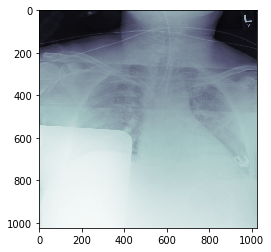

In [0]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
image_id = "1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436"
img = cv2.imread('train/'+ image_id + '.png',cv2.IMREAD_UNCHANGED)
mask = cv2.imread('masks/' + image_id + '.png',cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap=plt.cm.bone)
plt.imshow(mask,alpha=0.3,cmap="Reds")

plt.show()


Model building

In [0]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

import fastai
from fastai.vision import *
from mask_functions import *

In [0]:
fastai.__version__

'1.0.54'

In [0]:
SZ = 128
path = Path(f'.')

In [0]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        .add_test((path/'test').ls(), label=None)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(path=Path('.'), bs=64)
        .normalize(imagenet_stats))

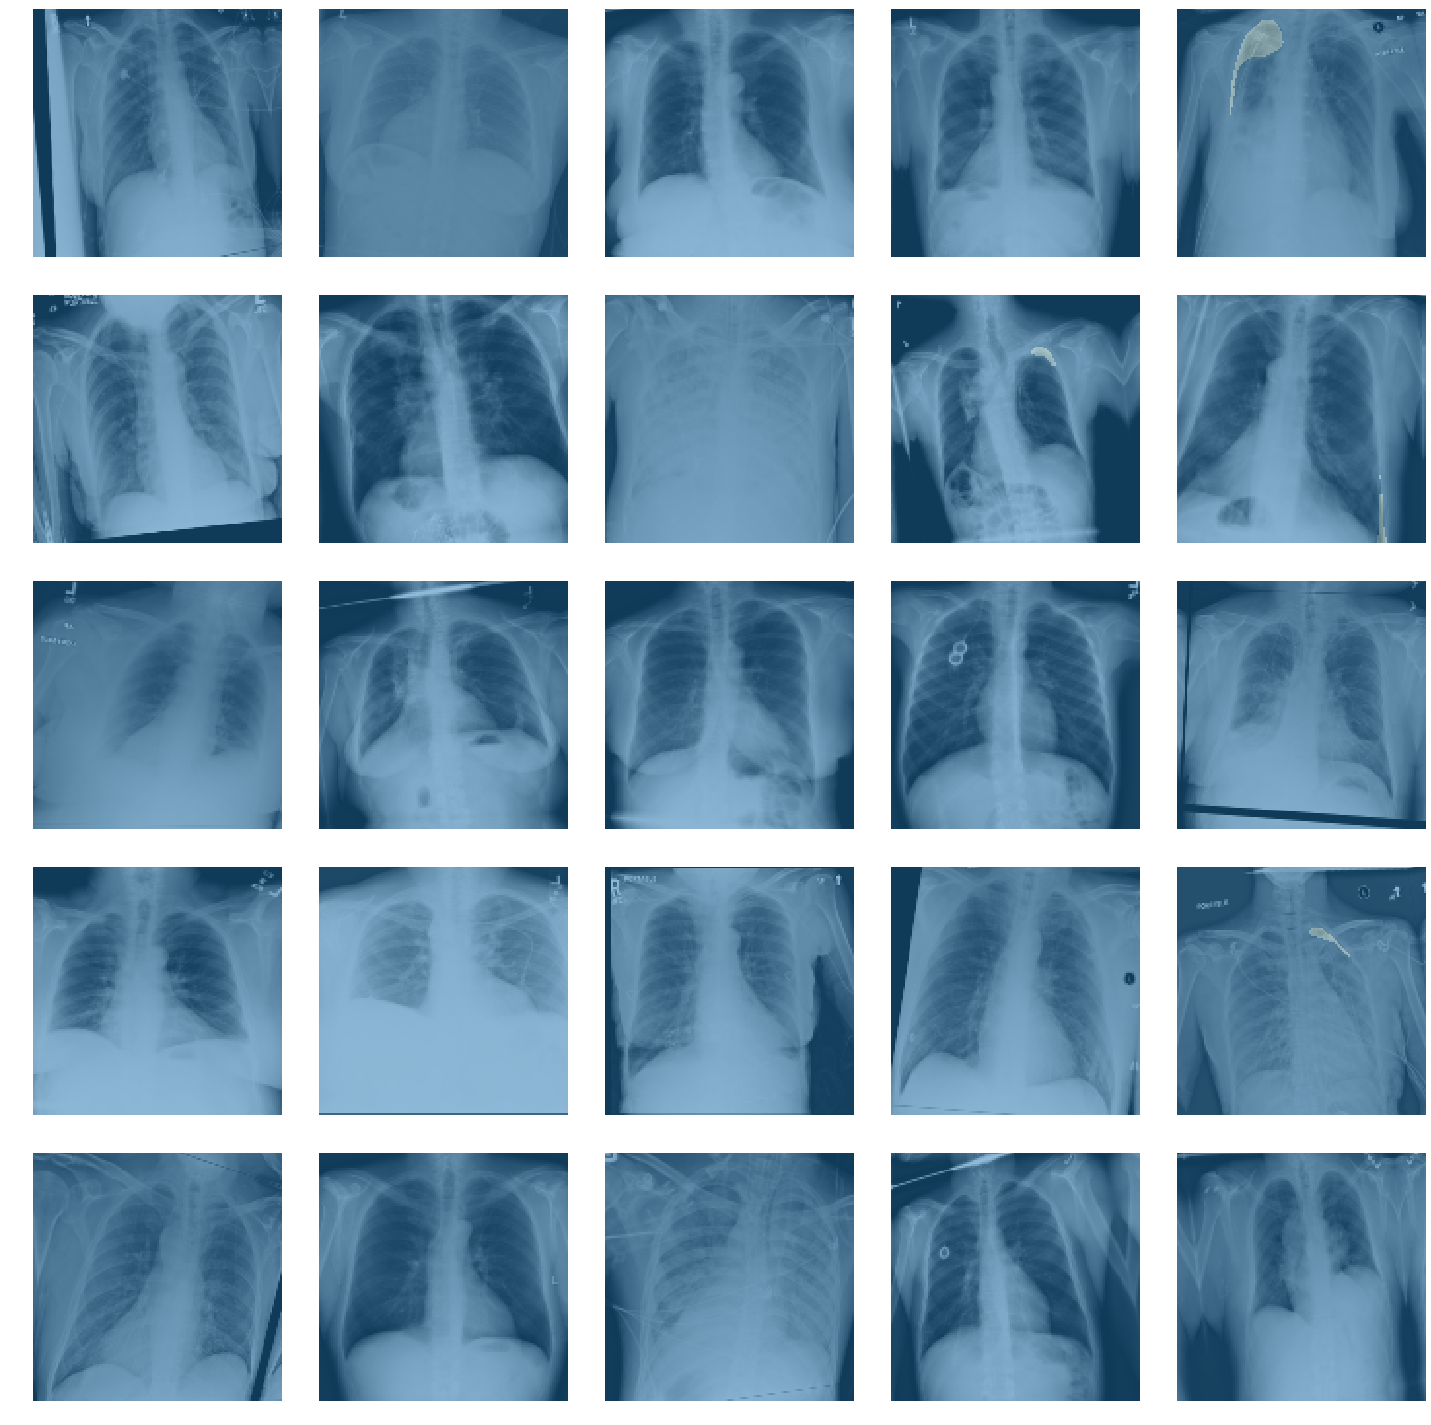

In [0]:
data.show_batch()

In [0]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=[dice])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22671265.59it/s]


In [0]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,dice,time


FileNotFoundError: ignored

In [0]:
rles_df[rles_df["ImageId"] == "1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436"]

,ImageId,masks
